<a href="https://colab.research.google.com/github/maminu-coder/Projects/blob/main/SPIDICR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# data_pipeline.py
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# %%


class DataPipeline:
    def __init__(self, dataset, dataset_path=None):
        self.dataset = dataset#pd.read_csv(dataset_path)

    def preprocess_environmental(self):
        """Process CPU/memory features inspired by frog vibration sensitivity [[9]]"""
        # Automatically select numerical features
        env_features = self.dataset.select_dtypes(include=['number'])

        # Handle missing values
        env_features = env_features.fillna(env_features.mean())

        # Normalize
        self.env_scaler = StandardScaler()
        return self.env_scaler.fit_transform(env_features)

    def preprocess_system_behavior(self):
        """Process sequential data like spider web patterns [[4]][[8]]"""

        # Automatically select numerical and categorical features
        # Excluding the 'Labels' column if it exists
        seq_features = self.dataset.select_dtypes(include=['number', 'object'])
        if 'Labels' in seq_features.columns:
            seq_features = seq_features.drop(columns=['Labels'])

        # One-hot encode categorical features
        categorical_features = seq_features.select_dtypes(include=['object']).columns

        # Create dummy variables if categorical features are present
        if len(categorical_features) > 0:
          seq_features = pd.get_dummies(seq_features, columns=categorical_features)

        # Create sequences using sliding window
        generator = TimeseriesGenerator(seq_features.values, seq_features.values,
                                       length=10, sampling_rate=1)
        return generator

    def split_data(self):
        # Split into benign/attack datasets
        benign = self.dataset[self.dataset['Labels'] == 'Normal']
        attack = self.dataset[self.dataset['Labels'] != 'Normal']
        return train_test_split(benign, test_size=0.2), attack

In [5]:


# class DataPipeline:
#     def __init__(self, dataset_path):
#         self.dataset = dataset_path#pd.read_csv(dataset_path)

#     def preprocess_environmental(self):
#         """Process CPU/memory features inspired by frog vibration sensitivity """
#         env_features = self.dataset[['cpu_usage', 'packet_rate', 'jitter',
#                                     'entropy', 'memory_usage', 'open_ports']]
#         # Handle missing values
#         env_features = env_features.fillna(env_features.mean())
#         # Normalize
#         self.env_scaler = StandardScaler()
#         return self.env_scaler.fit_transform(env_features)

#     def preprocess_system_behavior(self):
#         """Process sequential data like spider web patterns """
#         seq_features = self.dataset[['system_calls', 'flow_direction',
#                                    'packet_size', 'duration']]
#         # Encode categorical features
#         seq_features = pd.get_dummies(seq_features, columns=['flow_direction'])
#         # Create sequences using sliding window
#         generator = TimeseriesGenerator(seq_features.values, seq_features.values,
#                                        length=10, sampling_rate=1)
#         return generator

#     def split_data(self):
#         # Split into benign/attack datasets
#         benign = self.dataset[self.dataset['label'] == 'Benign']
#         attack = self.dataset[self.dataset['label'] != 'Benign']
#         return train_test_split(benign, test_size=0.2), attack

In [4]:
# frog_trigger.py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

class FrogTrigger:
    def __init__(self, input_dim):
        self.threshold = 0.0
        self.autoencoder = self.build_model(input_dim)

    def build_model(self, input_dim):
        """Autoencoder inspired by frog's environmental sensitivity [[9]]"""
        input_layer = Input(shape=(input_dim,))
        # Encoder
        encoded = Dense(64, activation='relu')(input_layer)
        encoded = Dense(32, activation='relu')(encoded)
        # Decoder
        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dense(input_dim, activation='sigmoid')(decoded)
        return Model(input_layer, decoded)

    def calculate_threshold(self, validation_data):
        """Set threshold at 99th percentile of reconstruction errors"""
        reconstructions = self.autoencoder.predict(validation_data)
        mse = np.mean(np.power(validation_data - reconstructions, 2), axis=1)
        self.threshold = np.percentile(mse, 99)

In [5]:
# spider_net.py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

class SpiderNet:
    def __init__(self, input_shape):
        self.model = self.build_model(input_shape)

    def build_model(self, input_shape):
        """BiLSTM inspired by spider's web vibration analysis """
        model = Sequential()
        model.add(Bidirectional(LSTM(64, return_sequences=True),
                               input_shape=input_shape))
        model.add(Bidirectional(LSTM(32)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.AUC()])
        return model

In [6]:
# controller.py
import numpy as np

class SPIDICRController:
    def __init__(self, frog_model, spider_model):
        self.phase = "HIBERNATION"
        self.frog = frog_model
        self.spider = spider_model

    def process_environmental(self, env_data):
        """Phase 1: Frog-based monitoring [[9]]"""
        if self.phase == "HIBERNATION":
            reconstruction = self.frog.autoencoder.predict(env_data)
            error = np.mean(np.power(env_data - reconstruction, 2))
            if error > self.frog.threshold:
                self.phase = "ACTIVATION"

    def process_sequences(self, seq_data):
        """Phase 2-3: Spider-based deep inspection [[4]][[8]]"""
        if self.phase == "ACTIVATION":
            prediction = self.spider.model.predict(seq_data)
            if prediction > 0.5:
                self.phase = "HUNT"
                return {"alert": True, "probability": prediction}
            self.phase = "HIBERNATION"

In [7]:
# reporting.py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

class SPIDICRReport:
    def __init__(self):
        self.alert_log = []

    def log_alert(self, alert):
        self.alert_log.append({
            'timestamp': pd.Timestamp.now(),
            'device_id': 'IoT-001',
            'probability': alert['probability']
        })

    def generate_metrics(self, y_true, y_pred):
        print(classification_report(y_true, y_pred))

    def plot_activations(self):
        # Timeline visualization of phase transitions
        plt.figure(figsize=(12, 6))
        plt.plot([alert['timestamp'] for alert in self.alert_log],
                [1]*len(self.alert_log), 'ro', markersize=10)
        plt.title('SPIDICR Activation Timeline')
        plt.show()

In [8]:
import os
import shutil

# Define source and destination directories
source_dir = "/content"  # Replace with your actual source directory if needed
destination_dir = "/content/drive/MyDrive/cic-iot-diad-2024"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Iterate through files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith(".csv"):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Move the file
        shutil.move(source_path, destination_path)
        print(f"Moved '{filename}' to '{destination_dir}'")


In [9]:
import os
import shutil

# Define source and destination directories
source_dir = "/content"  # Replace with your actual source directory if needed
destination_dir = "/content/drive/MyDrive/cic-iot-diad-2024"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Iterate through files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith(".csv"):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Move the file
        shutil.move(source_path, destination_path)
        print(f"Moved '{filename}' to '{destination_dir}'")


In [9]:
# 1. Download Dataset (Manual Step Required)
print("Please download the CIC IoT-DIAD 2024 dataset from: https://www.unb.ca/cic/datasets/iot-diad.html")
print("After downloading, extract and place the CSV files into a folder named 'CIC_IOT_DIAD_2024'.")

data_dir = os.path.expanduser("/content/drive/MyDrive/cic-iot-diad-2024/")#'CIC_IOT_DIAD_2024'
if not os.path.exists(data_dir):
    raise FileNotFoundError("Data directory 'CIC_IOT_DIAD_2024' not found. Please follow the instructions above.")



Please download the CIC IoT-DIAD 2024 dataset from: https://www.unb.ca/cic/datasets/iot-diad.html
After downloading, extract and place the CSV files into a folder named 'CIC_IOT_DIAD_2024'.


In [10]:
#Lets check the shape of one of the files
DDoS = pd.read_csv(os.path.join(data_dir, 'DDoS-ACK_Fragmentation3.csv'))
DDoS.describe()

<ipython-input-10-4e2206687849>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  DDoS = pd.read_csv(os.path.join(data_dir, 'DDoS-ACK_Fragmentation3.csv'))


,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,sum_p,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count
count,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,...,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,2.934770e+05,293477.000000,293477.000000,293477.000000,293477.000000
mean,30946.946817,13765.135346,4473.137033,379.538657,0.002290,1.049295,0.486253,0.025321,65.378629,890.473887,...,11030.063361,2.904575,1139.214133,527.991245,551.503168,4.033127e+05,1096.634798,5.255322,1091.379476,3.257823
std,41591.770804,19108.299195,8235.039652,257.607958,0.663625,1.021278,0.499812,0.157097,23.158447,593.880788,...,5517.685934,59.551847,593.499141,366.718932,275.884297,2.858947e+05,552.315490,77.635524,556.755443,4.212448
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,-1.000000,0.000000,0.000000,70.688962,0.000001,0.000000,0.000000,0.000000,64.000000,374.000000,...,3200.000000,0.000000,320.000000,160.000000,160.000000,2.694737e+04,320.000000,0.000000,320.000000,2.000000
50%,427.000000,508.000000,2682.000000,515.098316,0.000148,2.000000,0.000000,0.000000,64.000000,374.000000,...,14600.000000,0.000000,1460.000000,730.000000,730.000000,5.609474e+05,1460.000000,0.000000,1460.000000,3.000000
75%,59747.000000,20881.000000,6668.000000,594.781863,0.000521,2.000000,1.000000,0.000000,64.000000,1514.000000,...,14600.000000,0.000000,1460.000000,730.000000,730.000000,5.609474e+05,1460.000000,0.000000,1460.000000,3.000000
max,132088.000000,65224.000000,64956.000000,672.485182,359.504423,3.000000,1.000000,1.000000,255.000000,14546.000000,...,49957.000000,1460.000000,14492.000000,1460.000000,2497.850000,1.205053e+07,3029.250000,1460.000000,3017.250000,45.000000



#**Lets check the shape of one of the files**
## __Check for empty cells and handle them appropriately__
# __Option 1__: Drop rows with any empty cells
# DDoS.dropna(inplace=True)  # Use this if you want to remove rows with NaN

# __Option 2__: Fill empty cells with a specific value (e.g., mean, median, or a constant)
# For numerical features:
>numerical_cols = DDoS.select_dtypes(include=np.number).columns

>for col in numerical_cols:
   >> DDoS[col].fillna(DDoS[col].mean(), inplace=True)  # Fill NaN with the mean of each numerical column

# For categorical features:
>categorical_cols = DDoS.select_dtypes(include=['object']).columns

>for col in categorical_cols:
 >>   DDoS[col].fillna(DDoS[col].mode()[0], inplace=True)  # Fill NaN with the most frequent value


# __Option 3__: Use more advanced imputation techniques (KNNImputer, IterativeImputer)
>from sklearn.impute import KNNImputer, IterativeImputer

>imputer = KNNImputer(n_neighbors=5)  # Example using KNNImputer

>DDoS[numerical_cols] = imputer.fit_transform(DDoS[numerical_cols])



In [12]:
# #Lets check the shape of one of the files

print(DDoS.shape)

(293477, 135)


In [13]:
# Check for empty cells in the DDoS DataFrame
empty_cells = DDoS.isnull().sum()
print("Number of empty cells in each column:\n", empty_cells)

Number of empty cells in each column:
 stream                0
src_mac               0
dst_mac               0
src_ip             5585
dst_ip             5585
                   ... 
var_p                 0
q3_p                  0
q1_p                  0
iqr_p                 0
l3_ip_dst_count       0
Length: 135, dtype: int64


In [14]:
# Check for empty cells in the entire DataFrame
total_empty_cells = DDoS.isnull().sum().sum()
print("\nTotal number of empty cells in the DataFrame:", total_empty_cells)



Total number of empty cells in the DataFrame: 3220291


In [15]:
# Identify rows with any empty cells
rows_with_empty_cells = DDoS[DDoS.isnull().any(axis=1)]
print("\nRows with empty cells:\n", rows_with_empty_cells)


Rows with empty cells:
         stream              src_mac                    dst_mac  \
0           -1    dc:a6:32:c9:e4:ab  GoSund Smart plug WP2 (3)   
1           -1    e8:1b:69:f8:d4:e3  GoSund Smart plug WP2 (3)   
2           -1  Levoit Air Purifier          ff:ff:ff:ff:ff:ff   
3            0    dc:a6:32:c9:e4:ab  GoSund Smart plug WP2 (3)   
4           -1    dc:a6:32:c9:e4:ab  GoSund Smart plug WP2 (3)   
...        ...                  ...                        ...   
293472  132086    dc:a6:32:dc:27:d5  GoSund Smart Plug WP3 (1)   
293473      -1    dc:a6:32:dc:27:d5  GoSund Smart Plug WP3 (1)   
293474  132087    dc:a6:32:dc:27:d5  GoSund Smart Plug WP3 (1)   
293475      -1    dc:a6:32:dc:27:d5  GoSund Smart Plug WP3 (1)   
293476  132088    dc:a6:32:dc:27:d5  GoSund Smart Plug WP3 (1)   

                 src_ip           dst_ip  src_port  dst_port  \
0       192.168.137.196   192.168.137.32         0         0   
1        192.168.137.89   192.168.137.32         0    

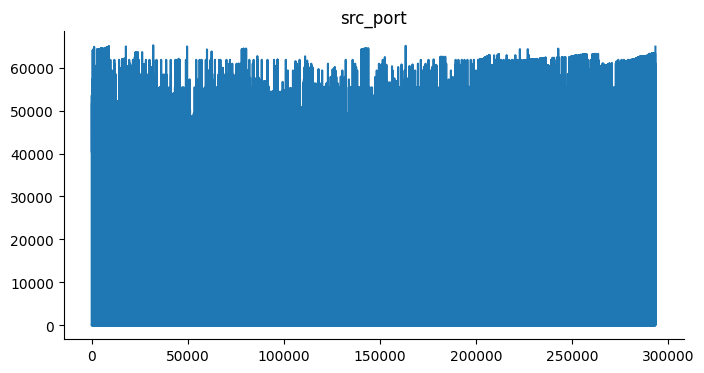

In [17]:
from matplotlib import pyplot as plt
DDoS['src_port'].plot(kind='line', figsize=(8, 4), title='src_port')
plt.gca().spines[['top', 'right']].set_visible(False)

In [27]:
def preprocessing(DDoS):
  print("before : ", DDoS.isnull().sum())
  for column in DDoS.columns:
      if pd.api.types.is_numeric_dtype(DDoS[column]):  # Check if the column is numeric
          DDoS[column].fillna(DDoS[column].mean(), inplace=True)
      elif pd.api.types.is_string_dtype(DDoS[column]):
          DDoS[column].fillna(DDoS[column].mode()[0], inplace=True)
  print("After : ", DDoS.isnull().sum())
  DDoS.drop_duplicates(inplace=True)

In [26]:
DDoS.drop_duplicates(inplace=True)

In [18]:
# 3. Basic Preprocessing
print("Preprocessing data...")
for column in DDoS.columns:
    if pd.api.types.is_numeric_dtype(DDoS[column]):  # Check if the column is numeric
        DDoS[column].fillna(DDoS[column].mean(), inplace=True)
    elif pd.api.types.is_string_dtype(DDoS[column]):
        DDoS[column].fillna(DDoS[column].mode()[0], inplace=True)

DDoS.isnull().sum()
DDoS.drop_duplicates(inplace=True)

Preprocessing data...


<ipython-input-18-16b899309161>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DDoS[column].fillna(DDoS[column].mean(), inplace=True)
<ipython-input-18-16b899309161>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

,0
stream,0
src_mac,0
dst_mac,0
src_ip,5585
dst_ip,5585
...,...
var_p,0
q3_p,0
q1_p,0
iqr_p,0


In [19]:
DDoS.describe()

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,sum_p,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count
count,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,...,293477.000000,293477.000000,293477.000000,293477.000000,293477.000000,2.934770e+05,293477.000000,293477.000000,293477.000000,293477.000000
mean,30946.946817,13765.135346,4473.137033,379.538657,0.002290,1.049295,0.486253,0.025321,65.378629,890.473887,...,11030.063361,2.904575,1139.214133,527.991245,551.503168,4.033127e+05,1096.634798,5.255322,1091.379476,3.257823
std,41591.770804,19108.299195,8235.039652,257.607958,0.663625,1.021278,0.499812,0.157097,23.158447,593.880788,...,5517.685934,59.551847,593.499141,366.718932,275.884297,2.858947e+05,552.315490,77.635524,556.755443,4.212448
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,-1.000000,0.000000,0.000000,70.688962,0.000001,0.000000,0.000000,0.000000,64.000000,374.000000,...,3200.000000,0.000000,320.000000,160.000000,160.000000,2.694737e+04,320.000000,0.000000,320.000000,2.000000
50%,427.000000,508.000000,2682.000000,515.098316,0.000148,2.000000,0.000000,0.000000,64.000000,374.000000,...,14600.000000,0.000000,1460.000000,730.000000,730.000000,5.609474e+05,1460.000000,0.000000,1460.000000,3.000000
75%,59747.000000,20881.000000,6668.000000,594.781863,0.000521,2.000000,1.000000,0.000000,64.000000,1514.000000,...,14600.000000,0.000000,1460.000000,730.000000,730.000000,5.609474e+05,1460.000000,0.000000,1460.000000,3.000000
max,132088.000000,65224.000000,64956.000000,672.485182,359.504423,3.000000,1.000000,1.000000,255.000000,14546.000000,...,49957.000000,1460.000000,14492.000000,1460.000000,2497.850000,1.205053e+07,3029.250000,1460.000000,3017.250000,45.000000


from matplotlib import pyplot as plt
_df_0['stream'].plot(kind='hist', bins=20, title='stream')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['src_port'].plot(kind='hist', bins=20, title='src_port')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['dst_port'].plot(kind='hist', bins=20, title='dst_port')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['inter_arrival_time'].plot(kind='hist', bins=20, title='inter_arrival_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='stream', y='src_port', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='src_port', y='dst_port', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='dst_port', y='inter_arrival_time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='inter_arrival_time', y='time_since_previously_displayed_frame', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['inter_arrival_time']
  ys = series['stream']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('inter_arrival_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('inter_arrival_time')
_ = plt.ylabel('stream')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['inter_arrival_time']
  ys = series['src_port']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('inter_arrival_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('inter_arrival_time')
_ = plt.ylabel('src_port')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['inter_arrival_time']
  ys = series['dst_port']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('inter_arrival_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('inter_arrival_time')
_ = plt.ylabel('dst_port')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['inter_arrival_time']
  ys = series['port_class_dst']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('inter_arrival_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('inter_arrival_time')
_ = plt.ylabel('port_class_dst')

from matplotlib import pyplot as plt
_df_12['stream'].plot(kind='line', figsize=(8, 4), title='stream')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['src_port'].plot(kind='line', figsize=(8, 4), title='src_port')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['dst_port'].plot(kind='line', figsize=(8, 4), title='dst_port')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['inter_arrival_time'].plot(kind='line', figsize=(8, 4), title='inter_arrival_time')
plt.gca().spines[['top', 'right']].set_visible(False)

In [20]:
#Lets check the shape of one of the files
DDoS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293477 entries, 0 to 293476
Columns: 135 entries, stream to l3_ip_dst_count
dtypes: float64(97), int64(22), object(16)
memory usage: 302.3+ MB


In [21]:
DDoS.head()

,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,sum_p,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count
0,-1,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1,e8:1b:69:f8:d4:e3,GoSund Smart plug WP2 (3),192.168.137.89,192.168.137.32,0,0,0.000963,0.000963,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1,Levoit Air Purifier,ff:ff:ff:ff:ff:ff,NaN,NaN,0,0,0.005656,0.004693,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,40270,6668,0.015167,0.009511,2,...,1460.0,0.0,1460.0,0.0,73.0,106580.0,0.0,0.0,0.0,1.0
4,-1,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,0,0,0.015168,0.000001,0,...,1460.0,0.0,1460.0,0.0,73.0,106580.0,0.0,0.0,0.0,1.0


In [22]:
DDoS["Labels"]="DDoS"
DDoS.head()

,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,Labels
0,-1,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DDoS
1,-1,e8:1b:69:f8:d4:e3,GoSund Smart plug WP2 (3),192.168.137.89,192.168.137.32,0,0,0.000963,0.000963,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DDoS
2,-1,Levoit Air Purifier,ff:ff:ff:ff:ff:ff,NaN,NaN,0,0,0.005656,0.004693,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DDoS
3,0,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,40270,6668,0.015167,0.009511,2,...,0.0,1460.0,0.0,73.0,106580.0,0.0,0.0,0.0,1.0,DDoS
4,-1,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,0,0,0.015168,0.000001,0,...,0.0,1460.0,0.0,73.0,106580.0,0.0,0.0,0.0,1.0,DDoS


In [23]:
list(DDoS.columns)

['stream',
 'src_mac',
 'dst_mac',
 'src_ip',
 'dst_ip',
 'src_port',
 'dst_port',
 'inter_arrival_time',
 'time_since_previously_displayed_frame',
 'port_class_dst',
 'l4_tcp',
 'l4_udp',
 'ttl',
 'eth_size',
 'tcp_window_size',
 'payload_entropy',
 'handshake_version',
 'handshake_cipher_suites_length',
 'handshake_ciphersuites',
 'handshake_extensions_length',
 'tls_server',
 'handshake_sig_hash_alg_len',
 'http_request_method',
 'http_host',
 'http_response_code',
 'user_agent',
 'dns_server',
 'dns_query_type',
 'dns_len_qry',
 'dns_interval',
 'dns_len_ans',
 'device_mac',
 'eth_src_oui',
 'eth_dst_oui',
 'payload_length',
 'highest_layer',
 'http_uri',
 'http_content_len',
 'http_content_type',
 'icmp_type',
 'icmp_checksum_status',
 'icmp_data_size',
 'jitter',
 'stream_1_count',
 'stream_1_mean',
 'stream_1_var',
 'src_ip_1_count',
 'src_ip_1_mean',
 'src_ip_1_var',
 'src_ip_mac_1_count',
 'src_ip_mac_1_mean',
 'src_ip_mac_1_var',
 'channel_1_count',
 'channel_1_mean',
 'chann

In [28]:
#Lets check the shape of one of the files
benign = pd.read_csv(os.path.join(data_dir, 'BenignTraffic.csv'))
preprocessing(benign)

before :  stream                 0
src_mac                0
dst_mac                0
src_ip             19259
dst_ip             19259
                   ...  
var_p                  0
q3_p                   0
q1_p                   0
iqr_p                  0
l3_ip_dst_count        0
Length: 135, dtype: int64


<ipython-input-27-30e3930a560c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DDoS[column].fillna(DDoS[column].mean(), inplace=True)
<ipython-input-27-30e3930a560c>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

After :  stream                 0
src_mac                0
dst_mac                0
src_ip             19259
dst_ip             19259
                   ...  
var_p                  0
q3_p                   0
q1_p                   0
iqr_p                  0
l3_ip_dst_count        0
Length: 135, dtype: int64


In [29]:
benign["Labels"]="Normal"
benign.head()

,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,Labels
0,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000000,0.000000,1,...,2908.0,2908.0,2908.0,2908.0,0.000000,2908.0,2908.0,0.0,1.0,Normal
1,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000164,0.000164,1,...,2908.0,2908.0,2908.0,2908.0,0.000000,2908.0,2908.0,0.0,1.0,Normal
2,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000269,0.000105,1,...,1460.0,2908.0,2908.0,2835.6,104835.200000,2908.0,2908.0,0.0,1.0,Normal
3,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000414,0.000145,1,...,1460.0,2908.0,2908.0,2763.2,198635.115789,2908.0,2908.0,0.0,1.0,Normal
4,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.001800,0.001386,1,...,1460.0,2908.0,2908.0,2690.8,281399.747368,2908.0,2908.0,0.0,1.0,Normal


In [30]:
notFeature = []
featureDDoS = list(DDoS.columns)
featureB = list(benign.columns)
for i in featureB:
  if i in featureDDoS:
    print(f"Feature name {i} is in DDoS")
  else:
    notFeature.append(i)

Feature name stream is in DDoS
Feature name src_mac is in DDoS
Feature name dst_mac is in DDoS
Feature name src_ip is in DDoS
Feature name dst_ip is in DDoS
Feature name src_port is in DDoS
Feature name dst_port is in DDoS
Feature name inter_arrival_time is in DDoS
Feature name time_since_previously_displayed_frame is in DDoS
Feature name port_class_dst is in DDoS
Feature name l4_tcp is in DDoS
Feature name l4_udp is in DDoS
Feature name ttl is in DDoS
Feature name eth_size is in DDoS
Feature name tcp_window_size is in DDoS
Feature name payload_entropy is in DDoS
Feature name handshake_version is in DDoS
Feature name handshake_cipher_suites_length is in DDoS
Feature name handshake_ciphersuites is in DDoS
Feature name handshake_extensions_length is in DDoS
Feature name tls_server is in DDoS
Feature name handshake_sig_hash_alg_len is in DDoS
Feature name http_request_method is in DDoS
Feature name http_host is in DDoS
Feature name http_response_code is in DDoS
Feature name user_agent is 

In [31]:
concatenated_df = pd.concat([DDoS, benign], ignore_index=True)
concatenated_df.head()

,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,Labels
0,-1,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DDoS
1,-1,e8:1b:69:f8:d4:e3,GoSund Smart plug WP2 (3),192.168.137.89,192.168.137.32,0,0,0.000963,0.000963,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DDoS
2,-1,Levoit Air Purifier,ff:ff:ff:ff:ff:ff,NaN,NaN,0,0,0.005656,0.004693,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DDoS
3,0,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,40270,6668,0.015167,0.009511,2,...,0.0,1460.0,0.0,73.0,106580.0,0.0,0.0,0.0,1.0,DDoS
4,-1,dc:a6:32:c9:e4:ab,GoSund Smart plug WP2 (3),192.168.137.196,192.168.137.32,0,0,0.015168,0.000001,0,...,0.0,1460.0,0.0,73.0,106580.0,0.0,0.0,0.0,1.0,DDoS


In [32]:
# print("Preprocessing data...")
# benign.dropna(inplace=True)
# benign.drop_duplicates(inplace=True)
# benign.info()

Preprocessing data...
<class 'pandas.core.frame.DataFrame'>
Index: 4949 entries, 521 to 296847
Columns: 136 entries, stream to Labels
dtypes: float64(97), int64(22), object(17)
memory usage: 5.2+ MB


In [ ]:
# dfs_by_columns = {}
# columns = tuple(benign.columns)
# if columns in dfs_by_columns:
#     dfs_by_columns[columns].append(df)
# else:
#     dfs_by_columns[columns] = [df]
# for columns, dfs in dfs_by_columns.items():
#   if len(dfs) > 1:
#       concatenated_df = pd.concat(dfs, ignore_index=True)
#       output_filename = os.path.join(directory, f"concatenated_{'_'.join(columns[:3])}.csv")
#       # Use first 3 columns for file name

#       concatenated_df.to_csv(output_filename, index=False)
#       print(f"Concatenated {len(dfs)} files with columns into '{output_filename}'")


In [16]:
# # prompt: check if .csv files have the same columns, if yes, concate, if no, continue. Finally create another file to all .csv with same column and concate them. save the concate to file

# import pandas as pd
# import os

# def concatenate_csv_files(directory):
#     """
#     Concatenates CSV files in a directory if they have the same columns.

#     Args:
#         directory: The path to the directory containing the CSV files.
#     """

#     csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
#     if not csv_files:
#         print("No CSV files found in the directory.")
#         return

#     # Create a dictionary to store DataFrames with the same columns
#     dfs_by_columns = {}

#     for file in csv_files:
#         filepath = os.path.join(directory, file)
#         try:
#             df = pd.read_csv(filepath)
#             columns = tuple(df.columns)  # Use a tuple as dictionary keys must be immutable

#             if columns in dfs_by_columns:
#                 dfs_by_columns[columns].append(df)
#             else:
#                 dfs_by_columns[columns] = [df]
#         except pd.errors.EmptyDataError:
#             print(f"Warning: Skipping empty file '{file}'.")
#         except pd.errors.ParserError:
#             print(f"Warning: Skipping file '{file}' due to parsing error.")


#     for columns, dfs in dfs_by_columns.items():
#         if len(dfs) > 1:
#             concatenated_df = pd.concat(dfs, ignore_index=True)
#             output_filename = os.path.join(directory, f"concatenated_{'_'.join(columns[:3])}.csv")  # Use first 3 columns for file name

#             concatenated_df.to_csv(output_filename, index=False)
#             print(f"Concatenated {len(dfs)} files with columns into '{output_filename}'")

# # Example usage: Replace with your actual data directory
# data_dir = "/content/drive/MyDrive/cic-iot-diad-2024"
# concatenate_csv_files(data_dir)


<ipython-input-16-34aedaf0a10a>:25: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
<ipython-input-16-34aedaf0a10a>:25: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
<ipython-input-16-34aedaf0a10a>:25: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
<ipython-input-16-34aedaf0a10a>:25: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
<ipython-input-16-34aedaf0a10a>:25: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
<ipython-input-16-34aedaf0a10a>:25: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
<ipy

Concatenated 12 files with columns ('stream', 'src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'inter_arrival_time', 'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'eth_size', 'tcp_window_size', 'payload_entropy', 'handshake_version', 'handshake_cipher_suites_length', 'handshake_ciphersuites', 'handshake_extensions_length', 'tls_server', 'handshake_sig_hash_alg_len', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_query_type', 'dns_len_qry', 'dns_interval', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'payload_length', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'jitter', 'stream_1_count', 'stream_1_mean', 'stream_1_var', 'src_ip_1_count', 'src_ip_1_mean', 'src_ip_1_var', 'src_ip_mac_1_count', 'src_ip_mac_1_mean', 'src_ip_mac_1_var', 'channel_1_count', 'channel_1_mean', 'channel_1_var', 'stream_

In [ ]:
# # 2. Load Data
# print("Loading dataset...")
# csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') ]
# df_list = [pd.read_csv(os.path.join(data_dir, f)) for f in csv_files]
# df = pd.concat(df_list, ignore_index=True)

In [ ]:
df.describe()

In [ ]:
# import requests
# import os

# def download_dataset(url, filename):
#     """Downloads a dataset from a given URL and saves it to a specified file."""
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()  # Raise an exception for non-200 status codes

#         with open(filename, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)

#         print(f"Dataset downloaded successfully to {filename}")

#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading dataset: {e}")

#     except Exception as e:
#         print(f"An unexpected error occurred: {e}")

# # Example usage (replace with your actual dataset URL and desired filename)
# dataset_url = "http://cicresearch.ca/IOTDataset/CIC%20IoT-IDAD%20Dataset%202024/Dataset/Device%20Identification_Anomaly%20Detection%20-%20Packet%20Based%20Features/CIC2023/Spoofing/MITM-ArpSpoofing/"  # Replace with the actual URL
# #dataset_filename = "cic-iot-diad-2024.csv"
# dataset_filename = "MITM-ArpSpoofing1.csv"
# download_dataset(dataset_url+dataset_filename, dataset_filename)
# # home_dir = "/content/drive/MyDrive/cic-iot-diad-2024/"
# # for i in range(1,22):
# #   dataset_filename = home_dir + "Mirai-greip_flood"+str(i)+".csv"
# #   print(dataset_filename)
# #   download_dataset(dataset_url, dataset_filename)




Dataset downloaded successfully to MITM-ArpSpoofing1.csv


In [33]:
# import requests
# import os
# from bs4 import BeautifulSoup
# from urllib.parse import urljoin
# home_dir = "/content/drive/MyDrive/cic-iot-diad-2024/"

# def download_csv_files(url):
#     try:
#         response = requests.get(url)
#         response.raise_for_status()  # Raise an exception for bad status codes

#         soup = BeautifulSoup(response.content, 'html.parser')
#         for link in soup.find_all('a'):
#             href = link.get('href')
#             absolute_url = urljoin(url, href)

#             if href.endswith('.csv'):
#                 filename = os.path.basename(href)
#                 download_file(absolute_url, home_dir+filename)

#             elif href.endswith('/'):  # Check if it's a subdirectory
#               download_csv_files(absolute_url)


#     except requests.exceptions.RequestException as e:
#         print(f"Error accessing URL {url}: {e}")
#     except Exception as e:
#         print(f"An error occurred: {e}")

# def download_file(url, filename):
#   try:
#     response = requests.get(url, stream=True)
#     response.raise_for_status()

#     with open(filename, 'wb') as file:
#       for chunk in response.iter_content(chunk_size=8192):
#         file.write(chunk)

#     print(f"Downloaded: {filename}")

#   except requests.exceptions.RequestException as e:
#     print(f"Error downloading file {url}: {e}")
#   except Exception as e:
#     print(f"An error occurred while downloading {url}: {e}")

# if __name__ == "__main__":
#     base_url = "http://cicresearch.ca/IOTDataset/CIC%20IoT-IDAD%20Dataset%202024/Dataset/Device%20Identification_Anomaly%20Detection%20-%20Packet%20Based%20Features/CIC2023/"
#     download_csv_files(base_url)

In [32]:
from sys import version
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# %%


class DataPipeline:
    def __init__(self, dataset, dataset_path=None):
        self.dataset = dataset#pd.read_csv(dataset_path)

    def preprocess_environmental(self):
        """Process CPU/memory features inspired by frog vibration sensitivity [[9]]"""
        # Automatically select numerical features
        env_features = self.dataset.select_dtypes(include=['number'])

        # Handle missing values
        env_features = env_features.fillna(env_features.mean())

        # Normalize
        self.env_scaler = StandardScaler()
        return self.env_scaler.fit_transform(env_features)

    def preprocess_system_behavior(self):
        """Process sequential data like spider web patterns [[4]][[8]]"""

        # Automatically select numerical and categorical features
        # Excluding the 'Labels' column if it exists
        seq_features = self.dataset.select_dtypes(include=['number', 'object'])
        if 'Labels' in seq_features.columns:
            seq_features = seq_features.drop(columns=['Labels'])

        # One-hot encode categorical features
        categorical_features = seq_features.select_dtypes(include=['object']).columns

        # Create dummy variables if categorical features are present
        if len(categorical_features) > 0:
            seq_features = pd.get_dummies(seq_features, columns=categorical_features)

        # Convert all columns to numeric dtype
        #This line will fix the issue by changing the dtype
        seq_features = seq_features.astype(float)


        # Create sequences using sliding window
        generator = TimeseriesGenerator(seq_features.values, seq_features.values,
                                       length=10, sampling_rate=1)
        return generator

    def split_data(self):
        # Split into benign/attack datasets
        benign = self.dataset[self.dataset['Labels'] == 'Normal']
        attack = self.dataset[self.dataset['Labels'] != 'Normal']
        return train_test_split(benign, test_size=0.2), attack



#new version
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# %%


class DataPipeline:
    def __init__(self, dataset, dataset_path=None):
        self.dataset = dataset#pd.read_csv(dataset_path)

    def preprocess_environmental(self):
        """Process CPU/memory features inspired by frog vibration sensitivity [[9]]"""
        # Automatically select numerical features
        env_features = self.dataset.select_dtypes(include=['number'])

        # Handle missing values
        env_features = env_features.fillna(env_features.mean())

        # Normalize
        self.env_scaler = StandardScaler()
        return self.env_scaler.fit_transform(env_features)

    def preprocess_system_behavior(self):
        """Process sequential data like spider web patterns [[4]][[8]]"""

        # Automatically select numerical and categorical features
        # Excluding the 'Labels' column if it exists
        seq_features = self.dataset.select_dtypes(include=['number', 'object'])
        if 'Labels' in seq_features.columns:
            seq_features = seq_features.drop(columns=['Labels'])

        # One-hot encode categorical features
        categorical_features = seq_features.select_dtypes(include=['object']).columns

        # Create dummy variables if categorical features are present
        if len(categorical_features) > 0:
            seq_features = pd.get_dummies(seq_features, columns=categorical_features)

        # Convert all columns to numeric dtype
        #This line will fix the issue by changing the dtype
        seq_features = seq_features.astype(float)


        # Create sequences using sliding window
        #The target data should be labels for each sequence, not all the features.
        #Assuming 'Labels' column contains the binary labels (0 or 1):
        labels = self.dataset['Labels'].map({'Normal': 0, 'DDoS': 1}).astype(int)
        generator = TimeseriesGenerator(seq_features.values, labels.values,
                                       length=10, sampling_rate=1)
        return generator

    def split_data(self):
        # Split into benign/attack datasets
        benign = self.dataset[self.dataset['Labels'] == 'Normal']
        attack = self.dataset[self.dataset['Labels'] != 'Normal']
        return train_test_split(benign, test_size=0.2), attack

In [ ]:
# Training example
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
if __name__ == "__main__":
    # Data preparation
    pipeline = DataPipeline(concatenated_df) #('/content/drive/MyDrive/cic-iot-diad-2024/MITM-ArpSpoofing1.csv')
    env_data = pipeline.preprocess_environmental()
    seq_generator = pipeline.preprocess_system_behavior()

    # FrogTrigger training
    frog = FrogTrigger(input_dim=env_data.shape[1])
    frog.autoencoder.compile(optimizer='adam', loss='mse')
    frog.autoencoder.fit(env_data, env_data, epochs=100)
    frog.calculate_threshold(env_data)

    # SpiderNet training
    spider = SpiderNet(input_shape=(10, seq_generator[0][0].shape[2]))
    spider.model.fit(seq_generator, epochs=100)

In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
# 3. Basic Preprocessing

print("Preprocessing data...")
df = concatenated_df
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# 4. Encode labels (e.g., 'BENIGN', 'DoS', etc.)
if 'Labels' not in df.columns:
    raise ValueError("Expected 'Label' column not found.")
label_encoder = LabelEncoder()
df['Labels'] = label_encoder.fit_transform(df['Labels'])

# 5. Feature Selection
X = df.drop(columns=['Labels'])
y = df['Labels']

categorical_features = X.select_dtypes(include=['object', 'int']).columns  # Include 'int' for mixed-type columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for numpy array

# Convert mixed-type columns to strings before encoding
for feature in categorical_features:
    X[feature] = X[feature].astype(str)

# Fit and transform the categorical features
encoded_data = encoder.fit_transform(X[categorical_features])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))

# Drop the original categorical features and concatenate the encoded features
X = X.drop(columns=categorical_features)
X = pd.concat([X, encoded_df], axis=1)
# --- Changes end here ---


# 6. Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 8. Model Architecture (SpiderNet BiLSTM)
print("Training model...")
timesteps = 1
features = X_train.shape[1]
X_train = np.reshape(X_train, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, features))

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, features)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stop])

# 9. Evaluation
print("Evaluating model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Preprocessing data...
Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7295 - loss: 0.5883 - val_accuracy: 0.7853 - val_loss: 0.3234
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9963 - loss: 0.1044 - val_accuracy: 0.8618 - val_loss: 0.2411
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.8890 - val_loss: 0.2233
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.8984 - val_loss: 0.2179
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9026 - val_loss: 0.2149
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9058 - val_loss: 0.2131
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9079 - val_loss: 0.2116
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9079

In [45]:
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=[early_stop])

# 9. Evaluation
print("Evaluating model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 1.0000 - loss: 8.0675e-04 - val_accuracy: 0.9204 - val_loss: 0.2043
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 8.1468e-04 - val_accuracy: 0.9204 - val_loss: 0.2035
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.1303e-04 - val_accuracy: 0.9215 - val_loss: 0.2027
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.9862e-04 - val_accuracy: 0.9225 - val_loss: 0.2020
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.7077e-04 - val_accuracy: 0.9236 - val_loss: 0.2014
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 7.4182e-04 - val_accuracy: 0.9246 - val_loss: 0.2007
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 7.3704e-04 - val_accuracy: 0.9246 - val_loss: 0.2001
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - los

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Function to plot reconstruction error histogram
def plot_reconstruction_error(errors, threshold):
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title("FrogTrigger Reconstruction Error")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.savefig("reconstruction_error_plot.png")
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    plt.show()

# Assume 'recon_errors', 'threshold', 'y_test', 'predicted_labels', and 'predictions' already exist from main pipeline



In [28]:
def calculate_confusion_matrix(y_true, y_pred):
    """Calculates and plots the confusion matrix.
    Args:
        y_true: True labels.
        y_pred: Predicted labels.
    Returns:
        The confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(y_true, y_pred)  # Assuming plot_confusion_matrix is defined elsewhere
    return cm

def calculate_classification_report(y_true, y_pred):
    """Calculates and prints the classification report.
    Args:
        y_true: True labels.
        y_pred: Predicted labels.
    Returns:
         The classification report as a string.
    """
    report = classification_report(y_true, y_pred)
    print(report)
    return report


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       215
           1       0.99      0.92      0.95       979

    accuracy                           0.92      1194
   macro avg       0.85      0.93      0.89      1194
weighted avg       0.94      0.92      0.93      1194

Confusion Matrix:
 [[203  12]
 [ 78 901]]


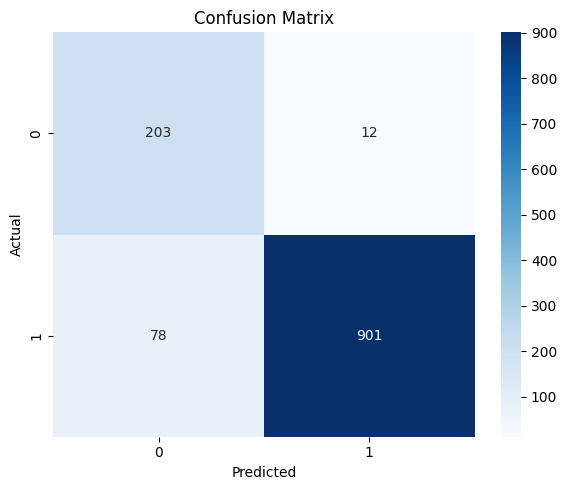

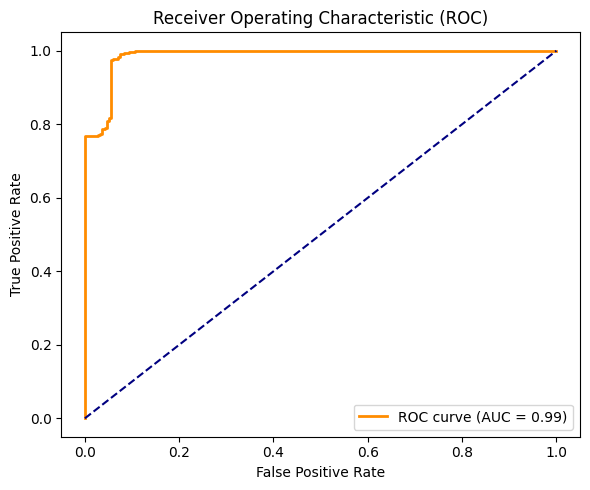

In [29]:
# Save the trained model
model.save('/content/drive/MyDrive/trained_model.h5')

# Load the saved model
loaded_model = keras.models.load_model('/content/drive/MyDrive/trained_model.h5')

# Reporting and analysis (example using loaded_model)
y_pred_prob = loaded_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) # Adjust threshold if necessary

# Classification Report
report = classification_report(y_test, y_pred)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_prob)


In [30]:

import tensorflow as tf

def convert_and_deploy(model_path, tflite_path):
    """
    Converts a TensorFlow Keras model to TensorFlow Lite format and prepares it for deployment.

    Args:
        model_path: Path to the saved Keras model (.h5 file).
        tflite_path: Path to save the converted TensorFlow Lite model (.tflite file).
    """

    # Load the Keras model
    model = tf.keras.models.load_model(model_path)

    # Convert the model to TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TFLite model
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print(f"TensorFlow Lite model saved to: {tflite_path}")

# Example usage
convert_and_deploy('/content/drive/MyDrive/trained_model.h5', '/content/drive/MyDrive/trained_model.tflite')

Saved artifact at '/tmp/tmpek0ro1x7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 6578), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140091869908624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869909392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869909968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869905936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869916112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869908432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869913232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869914000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869914576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869911888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140091869912656: 

ConverterError: Variable constant folding is failed. Please consider using enabling `experimental_enable_resource_variables` flag in the TFLite converter object. For example, converter.experimental_enable_resource_variables = True<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential_1_1/bidirectional_2_1/backward_lstm_2_1/TensorArrayV2_1@__inference_function_450559"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_450626"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential_1_1/bidirectional_2_1/backward_lstm_2_1/TensorArrayV2_1@__inference_function_450559"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_450626"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [ ]:
import tensorflow as tf

def convert_and_deploy(model_path, tflite_path):
    """
    Converts a TensorFlow Keras model to TensorFlow Lite format and prepares it for deployment.

    Args:
        model_path: Path to the saved Keras model (.h5 file).
        tflite_path: Path to save the converted TensorFlow Lite model (.tflite file).
    """

    # Load the Keras model
    model = tf.keras.models.load_model(model_path)

    # Convert the model to TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TFLite model
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print(f"TensorFlow Lite model saved to: {tflite_path}")

# Example usage
convert_and_deploy('/content/drive/MyDrive/trained_model.h5', '/content/drive/MyDrive/trained_model.tflite')


In [26]:
# Visualize
plot_reconstruction_error(recon_errors, threshold)
plot_confusion_matrix(y_test, predicted_labels)
plot_roc_curve(y_test, predictions)


NameError: name 'recon_errors' is not defined